In [1]:
import pandas as pd
import numpy as np
import jinja2
import matplotlib

In [2]:
medicamentos_2024 = pd.read_excel('2024.xls', skiprows=41)
medicamentos_2023 = pd.read_excel('2023.xls', skiprows=41)
medicamentos_2022 = pd.read_excel('2022.xls', skiprows=48)
medicamentos_2021 = pd.read_excel('2021.xls', skiprows=44)

In [3]:
# drop primeira linha 2023
medicamentos_2023 = medicamentos_2023.drop(index=0)

In [4]:
medicamentos = pd.read_excel('xls_conformidade_site_20251208_170820642.xlsx', skiprows=41)

In [5]:
medicamentos.columns

Index(['SUBSTÂNCIA', 'CNPJ', 'LABORATÓRIO', 'CÓDIGO GGREM', 'REGISTRO',
       'EAN 1', 'EAN 2', 'EAN 3', 'PRODUTO', 'APRESENTAÇÃO',
       'CLASSE TERAPÊUTICA', 'TIPO DE PRODUTO (STATUS DO PRODUTO)',
       'REGIME DE PREÇO', 'PF Sem Impostos', 'PF 0%', 'PF 12 %',
       'PF 12 %  ALC', 'PF 17 %', 'PF 17 %  ALC', 'PF 17,5 %',
       'PF 17,5 %  ALC', 'PF 18 %', 'PF 18 %  ALC', 'PF 19 %', 'PF 19 %  ALC',
       'PF 19,5 %', 'PF 19,5 %  ALC', 'PF 20 %', 'PF 20 %  ALC', 'PF 20,5 %',
       'PF 20,5 %  ALC', 'PF 21 %', 'PF 21 %  ALC', 'PF 22 %', 'PF 22 %  ALC',
       'PF 22,5 %', 'PF 22,5 %  ALC', 'PF 23 %', 'PF 23 %  ALC',
       'PMC Sem Impostos', 'PMC 0 %', 'PMC 12 %', 'PMC 12 %  ALC', 'PMC 17 %',
       'PMC 17 %  ALC', 'PMC 17,5 %', 'PMC 17,5 %  ALC', 'PMC 18 %',
       'PMC 18 %  ALC', 'PMC 19 %', 'PMC 19 %  ALC', 'PMC 19,5 %',
       'PMC 19,5 %  ALC', 'PMC 20 %', 'PMC 20 %  ALC', 'PMC 20,5 %',
       'PMC 20,5 %  ALC', 'PMC 21 %', 'PMC 21 %  ALC', 'PMC 22 %',
       'PMC 22 %  A

In [6]:
def tratamento_medicamentos(medicamentos):
    # Fazer uma cópia para não modificar o original
    medicamentos = medicamentos.copy()
    
    # Strip colunas de texto PRIMEIRO
    medicamentos.columns = medicamentos.columns.str.strip()
    
    # Verificar se já foi processado
    if 'tipo_produto' in medicamentos.columns:
        print("DataFrame já foi processado anteriormente!")
        return medicamentos
    
    # DEBUG: Mostrar algumas colunas
    print("Primeiras colunas:", medicamentos.columns[:10].tolist())
    
    ## Tratar valores não informados na coluna 'TIPO DE PRODUTO (STATUS DO PRODUTO)'
    if 'TIPO DE PRODUTO (STATUS DO PRODUTO)' in medicamentos.columns:
        nao_informado = medicamentos['TIPO DE PRODUTO (STATUS DO PRODUTO)'] == '    -     '
        medicamentos.loc[nao_informado, 'TIPO DE PRODUTO (STATUS DO PRODUTO)'] = 'Não Informado'
    
    # Identificar as colunas PMC corretas dinamicamente
    pmc_cols = [col for col in medicamentos.columns if 'PMC' in col]
    print(f"\nColunas PMC encontradas: {len(pmc_cols)}")
    
    # Encontrar PMC 18% e PMC 0%
    pmc_18_candidates = [col for col in medicamentos.columns if 'PMC' in col and '18' in col and 'ALC' not in col]
    pmc_0_candidates = [col for col in medicamentos.columns if 'PMC' in col and '0' in col and 'Sem' not in col]
    
    if not pmc_18_candidates:
        print("ERRO: Coluna PMC 18% não encontrada!")
        print("Colunas disponíveis com PMC:", [col for col in medicamentos.columns if 'PMC' in col][:5])
        return medicamentos
    
    if not pmc_0_candidates:
        print("ERRO: Coluna PMC 0% não encontrada!")
        return medicamentos
    
    pmc_18_col = pmc_18_candidates[0]
    pmc_0_col = pmc_0_candidates[0]
    
    print(f"Usando coluna PMC 18%: '{pmc_18_col}'")
    print(f"Usando coluna PMC 0%: '{pmc_0_col}'")
    
    # Criar coluna preco_final_consumidor de forma mais robusta
    genericos = medicamentos['TIPO DE PRODUTO (STATUS DO PRODUTO)'] == 'Genérico'
    
    # Converter PMC 18% para numérico
    medicamentos['preco_final_consumidor'] = pd.to_numeric(
        medicamentos[pmc_18_col].astype(str).str.replace(',', '.').str.replace('*', ''),
        errors='coerce'
    )
    
    # Para genéricos, usar PMC 0%
    medicamentos.loc[genericos, 'preco_final_consumidor'] = pd.to_numeric(
        medicamentos.loc[genericos, pmc_0_col].astype(str).str.replace(',', '.').str.replace('*', ''),
        errors='coerce'
    )
    
    # Remover colunas desnecessárias - todas as colunas PF e PMC
    colunas_pf_pmc = [col for col in medicamentos.columns if col.startswith('PF ') or col.startswith('PMC ')]
    medicamentos.drop(columns=colunas_pf_pmc, inplace=True, errors='ignore')
    
    # Remoção outras colunas desnecessárias
    colunas_para_remover = [
        'CÓDIGO GGREM', 'CAP', 'CONFAZ 87', 'ANÁLISE RECURSAL', 'ICMS 0%',
        'LISTA DE CONCESSÃO DE CRÉDITO TRIBUTÁRIO (PIS/COFINS)',
        'DESTINAÇÃO COMERCIAL'
    ]
    medicamentos.drop(columns=colunas_para_remover, inplace=True, errors='ignore')

    # renomear colunas
    rename_dict = {
        'SUBSTÂNCIA': 'ativo',
        'LABORATÓRIO': 'laboratorio',
        'REGISTRO': 'registro',
        'PRODUTO': 'produto',
        'APRESENTAÇÃO': 'apresentacao',
        'CLASSE TERAPÊUTICA': 'classe_terapeutica',
        'TIPO DE PRODUTO (STATUS DO PRODUTO)': 'tipo_produto',
        'REGIME DE PREÇO': 'regime_preco',
        'RESTRIÇÃO HOSPITALAR': 'restricao_hospitalar',
        'TARJA': 'tarja'
    }
    
    # Adicionar coluna de comercialização baseado no que existe
    for ano in ['2024', '2023', '2022', '2021', '2020']:
        col_name = f'COMERCIALIZAÇÃO {ano}'
        if col_name in medicamentos.columns:
            rename_dict[col_name] = 'comercializavel'
            break
    
    medicamentos.rename(columns=rename_dict, inplace=True)

    # Ajustar tipos de dados
    if 'EAN 1' in medicamentos.columns:
        medicamentos['EAN 1'] = medicamentos['EAN 1'].astype(str)
    if 'EAN 2' in medicamentos.columns:
        medicamentos['EAN 2'] = medicamentos['EAN 2'].astype(str)
    if 'EAN 3' in medicamentos.columns:
        medicamentos['EAN 3'] = medicamentos['EAN 3'].astype(str)

    # Tratar valores faltantes
    medicamentos.replace('    -     ', np.nan, inplace=True)
    
    # Ajustar colunas booleanas
    if 'restricao_hospitalar' in medicamentos.columns:
        medicamentos['restricao_hospitalar'] = medicamentos['restricao_hospitalar'] == 'Sim'
    
    if 'comercializavel' in medicamentos.columns:
        medicamentos['comercializavel'] = medicamentos['comercializavel'] == 'Sim'
    
    # Tratar coluna tarja
    if 'tarja' in medicamentos.columns:
        sem_tarja = medicamentos['tarja'] == 'Tarja Sem Tarja'
        sem_tarja_definida = medicamentos['tarja'].astype(str).str.contains('\(\*', regex=True, na=False)

        medicamentos.loc[sem_tarja, 'tarja'] = 'Sem Tarja'
        medicamentos.loc[sem_tarja_definida, 'tarja'] = 'Sem Tarja' 
        
        # Remove (**) da coluna tarja
        medicamentos['tarja'] = medicamentos['tarja'].astype(str).str.replace(r'\(\*+\)', '', regex=True).str.strip()
    
    print("\nProcessamento concluído!")
    print(f"Shape final: {medicamentos.shape}")
    
    return medicamentos

<>:115: SyntaxWarning: "\(" is an invalid escape sequence. Such sequences will not work in the future. Did you mean "\\("? A raw string is also an option.
<>:115: SyntaxWarning: "\(" is an invalid escape sequence. Such sequences will not work in the future. Did you mean "\\("? A raw string is also an option.
C:\Users\henrique.mourao\AppData\Local\Temp\ipykernel_11992\2278274494.py:115: SyntaxWarning: "\(" is an invalid escape sequence. Such sequences will not work in the future. Did you mean "\\("? A raw string is also an option.
  sem_tarja_definida = medicamentos['tarja'].astype(str).str.contains('\(\*', regex=True, na=False)


In [7]:
medicamentos_2024 = tratamento_medicamentos(medicamentos_2024)
medicamentos_2024.head()

Primeiras colunas: ['SUBSTÂNCIA', 'CNPJ', 'LABORATÓRIO', 'CÓDIGO GGREM', 'REGISTRO', 'EAN 1', 'EAN 2', 'EAN 3', 'PRODUTO', 'APRESENTAÇÃO']

Colunas PMC encontradas: 21
Usando coluna PMC 18%: 'PMC 18%'
Usando coluna PMC 0%: 'PMC 0%'

Processamento concluído!
Shape final: (25010, 16)


,ativo,CNPJ,laboratorio,registro,EAN 1,EAN 2,EAN 3,produto,apresentacao,classe_terapeutica,tipo_produto,regime_preco,restricao_hospitalar,comercializavel,tarja,preco_final_consumidor
0,21-ACETATO DE DEXAMETASONA;CLOTRIMAZOL,18.459.628/0001-15,BAYER S.A.,1705600230032,7891106000956,NaN,NaN,BAYCUTEN N,"10 MG/G + 0,443 MG/G CREM DERM CT BG AL X 40 G",D7B2 - CORTICOESTERÓIDES ASSOCIADOS A ANTIMICO...,Novo,Regulado,False,True,Sem Tarja,48.22
1,ABATACEPTE,56.998.982/0001-07,BRISTOL-MYERS SQUIBB FARMACÊUTICA LTDA,1018003900019,7896016806469,NaN,NaN,ORENCIA,250 MG PO LIOF SOL INJ CT 1 FA + SER DESCARTÁVEL,M1C - AGENTES ANTI-REUMÁTICOS ESPECÍFICOS,Biológico,Regulado,True,True,Tarja Vermelha,NaN
2,ABATACEPTE,56.998.982/0001-07,BRISTOL-MYERS SQUIBB FARMACÊUTICA LTDA,1018003900078,7896016808197,NaN,NaN,ORENCIA,125 MG/ML SOL INJ SC CT 4 SER PREENC VD TRANS ...,M1C - AGENTES ANTI-REUMÁTICOS ESPECÍFICOS,Biológico,Regulado,False,True,Sem Tarja,10826.15
3,ABEMACICLIBE,43.940.618/0001-44,ELI LILLY DO BRASIL LTDA,1126001990018,7896382708442,NaN,NaN,VERZENIOS,50 MG COM REV CT BL AL AL X 30,L1H - INIBIDORES DE PROTEINA QUINASE,Novo,Regulado,False,True,Tarja Vermelha,5077.25
4,ABEMACICLIBE,43.940.618/0001-44,ELI LILLY DO BRASIL LTDA,1126001990034,7896382708466,NaN,NaN,VERZENIOS,100 MG COM REV CT BL AL AL X 30,L1H - INIBIDORES DE PROTEINA QUINASE,Novo,Regulado,False,True,Tarja Vermelha,10154.47


In [8]:
medicamentos = tratamento_medicamentos(medicamentos)

Primeiras colunas: ['SUBSTÂNCIA', 'CNPJ', 'LABORATÓRIO', 'CÓDIGO GGREM', 'REGISTRO', 'EAN 1', 'EAN 2', 'EAN 3', 'PRODUTO', 'APRESENTAÇÃO']

Colunas PMC encontradas: 26
Usando coluna PMC 18%: 'PMC 18 %'
Usando coluna PMC 0%: 'PMC 0 %'

Processamento concluído!
Shape final: (26775, 16)


In [9]:
medicamentos_2024 = tratamento_medicamentos(medicamentos_2024)
medicamentos_2024.head()

DataFrame já foi processado anteriormente!


,ativo,CNPJ,laboratorio,registro,EAN 1,EAN 2,EAN 3,produto,apresentacao,classe_terapeutica,tipo_produto,regime_preco,restricao_hospitalar,comercializavel,tarja,preco_final_consumidor
0,21-ACETATO DE DEXAMETASONA;CLOTRIMAZOL,18.459.628/0001-15,BAYER S.A.,1705600230032,7891106000956,NaN,NaN,BAYCUTEN N,"10 MG/G + 0,443 MG/G CREM DERM CT BG AL X 40 G",D7B2 - CORTICOESTERÓIDES ASSOCIADOS A ANTIMICO...,Novo,Regulado,False,True,Sem Tarja,48.22
1,ABATACEPTE,56.998.982/0001-07,BRISTOL-MYERS SQUIBB FARMACÊUTICA LTDA,1018003900019,7896016806469,NaN,NaN,ORENCIA,250 MG PO LIOF SOL INJ CT 1 FA + SER DESCARTÁVEL,M1C - AGENTES ANTI-REUMÁTICOS ESPECÍFICOS,Biológico,Regulado,True,True,Tarja Vermelha,NaN
2,ABATACEPTE,56.998.982/0001-07,BRISTOL-MYERS SQUIBB FARMACÊUTICA LTDA,1018003900078,7896016808197,NaN,NaN,ORENCIA,125 MG/ML SOL INJ SC CT 4 SER PREENC VD TRANS ...,M1C - AGENTES ANTI-REUMÁTICOS ESPECÍFICOS,Biológico,Regulado,False,True,Sem Tarja,10826.15
3,ABEMACICLIBE,43.940.618/0001-44,ELI LILLY DO BRASIL LTDA,1126001990018,7896382708442,NaN,NaN,VERZENIOS,50 MG COM REV CT BL AL AL X 30,L1H - INIBIDORES DE PROTEINA QUINASE,Novo,Regulado,False,True,Tarja Vermelha,5077.25
4,ABEMACICLIBE,43.940.618/0001-44,ELI LILLY DO BRASIL LTDA,1126001990034,7896382708466,NaN,NaN,VERZENIOS,100 MG COM REV CT BL AL AL X 30,L1H - INIBIDORES DE PROTEINA QUINASE,Novo,Regulado,False,True,Tarja Vermelha,10154.47


In [10]:
medicamentos_2023 = tratamento_medicamentos(medicamentos_2023)
medicamentos_2023.head()

Primeiras colunas: ['SUBSTÂNCIA', 'CNPJ', 'LABORATÓRIO', 'CÓDIGO GGREM', 'REGISTRO', 'EAN 1', 'EAN 2', 'EAN 3', 'PRODUTO', 'APRESENTAÇÃO']

Colunas PMC encontradas: 18
Usando coluna PMC 18%: 'PMC 18%'
Usando coluna PMC 0%: 'PMC 0%'

Processamento concluído!
Shape final: (29087, 16)


,ativo,CNPJ,laboratorio,registro,EAN 1,EAN 2,EAN 3,produto,apresentacao,classe_terapeutica,tipo_produto,regime_preco,restricao_hospitalar,comercializavel,tarja,preco_final_consumidor
1,BUTILBROMETO DE ESCOPOLAMINA,61.082.426/0002-07,COSMED INDUSTRIA DE COSMETICOS E MEDICAMENTOS ...,1.781709e+12,7896094921313,NaN,NaN,BUSCOPAN,20 MG SOL INJ CT 5 AMP VD TRANS X 1 ML,A3A - ANTIESPASMÓDICOS E ANTICOLINÉRGICOS PUROS,Novo,Regulado,False,True,Tarja Vermelha,14.83
2,CIPIONATO DE TESTOSTERONA,00.923.140/0001-31,EMS SIGMA PHARMA LTDA,1.356906e+12,7894916202671,NaN,NaN,DEPOSTERON,100 MG/ML SOL INJ CX 3 AMP VD AMB X 2 ML,"G3B - ANDRÓGENOS EXCLUINDO G3E, G3F",Similar,Regulado,False,True,Tarja Vermelha sob restrição,266.62
3,CLORIDRATO DE ESCETAMINA,51.780.468/0001-87,JANSSEN-CILAG FARMACÊUTICA LTDA,1.123634e+12,7896212479931,NaN,NaN,SPRAVATO,"140 MG/ML SOL SPR NAS CT FR VD TRANS X 0,2 ML ...",N6A9 - ANTIDEPRESSIVOS TODOS OS OUTROS,Novo,Regulado,True,True,Tarja Vermelha sob restrição,NaN
4,RITUXIMABE,61.286.647/0001-16,SANDOZ DO BRASIL INDÚSTRIA FARMACÊUTICA LTDA,1.004706e+12,7897595635211,NaN,NaN,RIXIMYO,10 MG/ML SOL DIL INFUS CT 1 FR VD TRANS X 50 ML,"L1G1 - ANTICORPOS MONOCLONAIS ANTINEOPLÁSICOS,...",Biológico,Regulado,True,True,Tarja Vermelha,NaN
5,ERDAFITINIBE,51.780.468/0001-87,JANSSEN-CILAG FARMACÊUTICA LTDA,1.123634e+12,7896212479979,NaN,NaN,ERFANDEL,3 MG COM REV CT BL AL PLAS PVC/PCTFE TRANS X 56,L1H9 - OUTROS ANTINEOPLÁSICOS INIBIDORES DA PR...,Novo,Regulado,False,True,Tarja Vermelha,62748.63


In [11]:
medicamentos_2022 = tratamento_medicamentos(medicamentos_2022)
medicamentos_2022.head()

Primeiras colunas: ['SUBSTÂNCIA', 'CNPJ', 'LABORATÓRIO', 'CÓDIGO GGREM', 'REGISTRO', 'EAN 1', 'EAN 2', 'EAN 3', 'PRODUTO', 'APRESENTAÇÃO']

Colunas PMC encontradas: 9
Usando coluna PMC 18%: 'PMC 18%'
Usando coluna PMC 0%: 'PMC 0%'

Processamento concluído!
Shape final: (28108, 16)


,ativo,CNPJ,laboratorio,registro,EAN 1,EAN 2,EAN 3,produto,apresentacao,classe_terapeutica,tipo_produto,regime_preco,restricao_hospitalar,comercializavel,tarja,preco_final_consumidor
0,VALPROATO DE SÓDIO,49.475.833/0001-06,BIOLAB SANUS FARMACÊUTICA LTDA,NaN,7896112401247,NaN,NaN,ÁCIDO VALPRÓICO,250 MG CAP GEL MOLE CT FR VD AMB X 100,N3A - ANTIEPILÉPTICOS,Similar,Regulado,False,True,Sem Tarja,60.83
1,SALICILATO DE FENILA;ÁCIDO SALICÍLICO;ÓXIDO DE...,33.379.884/0001-96,LABORATORIO SIMOES LTDA.,057600510011,7896210500354,NaN,NaN,TALCO ALÍVIO,TALQUEIRA C/ 100 G,D10A - ANTIACNEICOS TÓPICOS,Similar,Regulado,False,False,Sem Tarja,9.43
2,DIENOGESTE;VALERATO DE ESTRADIOL,56.990.534/0001-67,SCHERING DO BRASIL QUÍMICA E FARMACÊUTICA LTDA,1002001390025,7896116871497,NaN,NaN,CHARMELIE,COM REV A + COM REV B + COM REV C + COM REV D ...,G3A4 - PREPARAÇÕES CONTRACEPTIVAS TRIFÁSICAS,Não Informado,Regulado,False,False,Tarja Vermelha,200.78
3,MONTELUCASTE,45.987.013/0001-34,ORGANON FARMACÊUTICA LTDA.,1002900050014,7897337706575,NaN,NaN,SINGULAIR,5 MG COM MAST CT 3 BL AL PLAS INC X 10,R3J2 - ANTIASMÁTICOS/DPOC ANTILEUCOTRIENOS SIS...,Novo,Regulado,False,True,Sem Tarja,83.50
4,MONTELUCASTE,45.987.013/0001-34,ORGANON FARMACÊUTICA LTDA.,1002900050022,7897337706568,NaN,NaN,SINGULAIR,10 MG COM REV CT 3 BL AL PLAS INC X 10,R3J2 - ANTIASMÁTICOS/DPOC ANTILEUCOTRIENOS SIS...,Novo,Regulado,False,True,Sem Tarja,83.50


In [12]:
medicamentos_2021 = tratamento_medicamentos(medicamentos_2021)
medicamentos_2021.head()

Primeiras colunas: ['SUBSTÂNCIA', 'CNPJ', 'LABORATÓRIO', 'CÓDIGO GGREM', 'REGISTRO', 'EAN 1', 'EAN 2', 'EAN 3', 'PRODUTO', 'APRESENTAÇÃO']

Colunas PMC encontradas: 9
Usando coluna PMC 18%: 'PMC 18%'
Usando coluna PMC 0%: 'PMC 0%'

Processamento concluído!
Shape final: (26267, 16)


,ativo,CNPJ,laboratorio,registro,EAN 1,EAN 2,EAN 3,produto,apresentacao,classe_terapeutica,tipo_produto,regime_preco,restricao_hospitalar,comercializavel,tarja,preco_final_consumidor
0,21-ACETATO DE DEXAMETASONA;CLOTRIMAZOL,18.459.628/0001-15,BAYER S.A.,1705600230032,7891106000956,NaN,NaN,BAYCUTEN N,"10 MG/G + 0,443 MG/G CREM DERM CT BG AL X 40 G",D7B2 - CORTICOESTERÓIDES ASSOCIADOS A ANTIMICO...,Novo,Regulado,False,True,Tarja Vermelha,39.40
1,ABATACEPTE,56.998.982/0001-07,BRISTOL-MYERS SQUIBB FARMACÊUTICA LTDA,1018003900019,7896016806469,NaN,NaN,ORENCIA,250 MG PO LIOF SOL INFUS IV CT 1 FA + SER DESC...,M1C - AGENTES ANTI-REUMÁTICOS ESPECÍFICOS,Biológico,Regulado,True,True,Sem Tarja,NaN
2,ABATACEPTE,56.998.982/0001-07,BRISTOL-MYERS SQUIBB FARMACÊUTICA LTDA,1018003900027,7896016807442,NaN,NaN,ORENCIA,125 MG/ML SOL INJ SC CT SER PREENCHIDA,M1C - AGENTES ANTI-REUMÁTICOS ESPECÍFICOS,Biológico,Regulado,False,False,Tarja Vermelha,2211.74
3,ABATACEPTE,56.998.982/0001-07,BRISTOL-MYERS SQUIBB FARMACÊUTICA LTDA,1018003900078,7896016808197,NaN,NaN,ORENCIA,125 MG/ML SOL INJ SC CT 4 SER PREENC VD TRANS ...,M1C - AGENTES ANTI-REUMÁTICOS ESPECÍFICOS,Biológico,Regulado,False,True,Tarja Vermelha,8847.11
4,ABCIXIMABE,51.780.468/0001-87,JANSSEN-CILAG FARMACÊUTICA LTDA,1123634150015,7896212452453,NaN,NaN,REOPRO,2 MG/ML SOL INJ CT FA VD INC X 5 ML,"B1C3 - INIBIDORES DA AGREGAÇÃO PLAQUETÁRIA, AN...",Biológico Novo,Regulado,True,False,Tarja Vermelha,NaN


In [13]:
# ADICIONANDO COLUNA ANO
medicamentos['ano'] = 2025
medicamentos_2024['ano'] = 2024
medicamentos_2023['ano'] = 2023
medicamentos_2022['ano'] = 2022
medicamentos_2021['ano'] = 2021

# CONCATENANDO (Empilhando)
# ignore_index=True
historico_medicamentos = pd.concat([
    medicamentos, medicamentos_2024, 
    medicamentos_2023, medicamentos_2022, 
    medicamentos_2021
    ], ignore_index=True)

display(historico_medicamentos.head())

,ativo,CNPJ,laboratorio,registro,EAN 1,EAN 2,EAN 3,produto,apresentacao,classe_terapeutica,tipo_produto,regime_preco,restricao_hospitalar,comercializavel,tarja,preco_final_consumidor,ano
0,21-ACETATO DE DEXAMETASONA;CLOTRIMAZOL,18.459.628/0001-15,BAYER S.A.,1705600230032,7891106000956,NaN,NaN,BAYCUTEN N,"10 MG/G + 0,443 MG/G CREM DERM CT BG AL X 40 G",D7B2 - CORTICOESTERÓIDES ASSOCIADOS A ANTIMICO...,Novo,Regulado,False,True,Sem Tarja,49.06,2025
1,ABATACEPTE,56.998.982/0001-07,BRISTOL-MYERS SQUIBB FARMACÊUTICA LTDA,1018003900019,7896016806469,NaN,NaN,ORENCIA,250 MG PO LIOF SOL INJ CT 1 FA + SER DESCARTÁVEL,M1C - AGENTES ANTI-REUMÁTICOS ESPECÍFICOS,Biológico,Regulado,True,True,Tarja Vermelha,NaN,2025
2,ABATACEPTE,56.998.982/0001-07,BRISTOL-MYERS SQUIBB FARMACÊUTICA LTDA,1018003900078,7896016808197,NaN,NaN,ORENCIA,125 MG/ML SOL INJ SC CT 4 SER PREENC VD TRANS ...,M1C - AGENTES ANTI-REUMÁTICOS ESPECÍFICOS,Biológico,Regulado,False,True,Sem Tarja,11107.63,2025
3,ABEMACICLIBE,43.940.618/0001-44,ELI LILLY DO BRASIL LTDA,1126001990018,7896382708442,NaN,NaN,VERZENIOS,50 MG COM REV CT BL AL AL X 30,L1H - INIBIDORES DE PROTEINA QUINASE,Novo,Regulado,False,True,Tarja Vermelha,5104.43,2025
4,ABEMACICLIBE,43.940.618/0001-44,ELI LILLY DO BRASIL LTDA,1126001990034,7896382708466,NaN,NaN,VERZENIOS,100 MG COM REV CT BL AL AL X 30,L1H - INIBIDORES DE PROTEINA QUINASE,Novo,Regulado,False,True,Tarja Vermelha,10208.83,2025


In [14]:
historico_medicamentos.to_csv('historico_medicamentos.csv', index=False)

In [15]:
def buscar_remedios(termo_busca, df):
    """
    Busca por medicamentos no DataFrame fornecido.
    Ignora maiúsculas/minúsculas e acentuacão.
    """
    termo_busca = str(termo_busca).strip() # removeu espaços extras
    busca_ean = df['EAN 1'] == termo_busca
    
    if busca_ean.any():
        print(f"✅ Encontrado por Código de Barras (EAN): {termo_busca}")
        return df[busca_ean]
    
    elif (df['registro'] == termo_busca).any():
        print(f"✅ Encontrado por Registro: {termo_busca}")
        return df[df['registro'] == termo_busca]
    
    # segunda tentativa
    busca_por_ativo = df['ativo'].str.contains(termo_busca, case=False, na=False)
    
    if busca_por_ativo.any():
        print(f"✅ Encontrado por Princípio Ativo: '{termo_busca}'")
        return df[busca_por_ativo]
    
    # não achou nada
    print(f"❌ Nenhum medicamento encontrado para: '{termo_busca}'")
    return None


In [16]:
primeiro_filtro = medicamentos['produto'].str.contains("dorflex", case=False, na=False)
segundo_filtro = pd.Series([False]*len(medicamentos))
(primeiro_filtro | segundo_filtro).any()

np.True_

In [17]:
import unicodedata

def buscar_remedios(termo_busca, df):
    """
    Busca por medicamentos no DataFrame fornecido.
    Ignora maiúsculas/minúsculas e acentuacão.
    """
    termo_busca = str(termo_busca).strip()   
    termo_limpo = unicodedata.normalize('NFKD', termo_busca).encode('ascii', errors='ignore').decode('utf-8')

    busca_ean = df['registro'] == termo_busca
    
    if busca_ean.any():
        print(f"✅ Encontrado por Código de registro: {termo_busca}")
        return df[busca_ean]
    elif (df['EAN 1'] == termo_busca).any():
        print(f"✅ Encontrado por EAN 1: {termo_busca}")
        return df[df['EAN 1'] == termo_busca]

    mask_ativo = df['ativo'].str.contains(termo_limpo, case=False, na=False, regex=False)
    mask_produto = df['produto'].str.contains(termo_limpo, case=False, na=False, regex=False)

    resultados = df[mask_ativo | mask_produto]

    if not resultados.empty:
        print(f"✅ Encontrado(s) {len(resultados)} resultado(s) para: {termo_busca}")
        return resultados.head(10)
    else:
        print(f"❌ Nenhum resultado encontrado para: {termo_busca}")
        return pd.DataFrame()


In [18]:
termo_digitado = input("qual medicamento você quer buscar? ")
resultado = buscar_remedios(termo_digitado, medicamentos)
display(resultado)

✅ Encontrado(s) 6045 resultado(s) para: di


,ativo,CNPJ,laboratorio,registro,EAN 1,EAN 2,EAN 3,produto,apresentacao,classe_terapeutica,tipo_produto,regime_preco,restricao_hospitalar,comercializavel,tarja,preco_final_consumidor,ano
26,ACEBROFILINA,17.159.229/0001-76,LABORATORIO TEUTO BRASILEIRO S/A,1037005630031,7896112159254,NaN,NaN,DILABRONCO,10MG/ML XPE CT FR PLAS OPC X 120ML + COP,R5C - EXPECTORANTES,Similar,Regulado,False,False,Tarja Vermelha,41.53,2025
37,ACEBROFILINA,60.659.463/0029-92,ACHÉ LABORATÓRIOS FARMACÊUTICOS S.A,1057301270065,7896658002113,NaN,NaN,BRONDILAT,10 MG/ML XPE CT FR PLAS AMB X 120 ML + COP X ...,R5C - EXPECTORANTES,Similar,Regulado,False,True,Tarja Vermelha,75.52,2025
38,ACEBROFILINA,60.659.463/0029-92,ACHÉ LABORATÓRIOS FARMACÊUTICOS S.A,1057301270073,7896658002120,NaN,NaN,BRONDILAT,5 MG/ML XPE CT FR PLAS AMB X 120 ML + COP X 1...,R5C - EXPECTORANTES,Similar,Regulado,False,True,Tarja Vermelha,50.98,2025
39,ACEBROFILINA,60.659.463/0029-92,ACHÉ LABORATÓRIOS FARMACÊUTICOS S.A,1057301270091,7896658012167,NaN,NaN,BRONDILAT,10 MG/ML XPE CT FR PLAS AMB X 60 ML + COP X 1...,R5C - EXPECTORANTES,Similar,Regulado,False,True,Tarja Vermelha,37.70,2025
40,ACEBROFILINA,60.659.463/0029-92,ACHÉ LABORATÓRIOS FARMACÊUTICOS S.A,1057301270111,7896658012174,NaN,NaN,BRONDILAT,5 MG/ML XPE CT FR PLAS AMB X 60 ML + COP X 10 ML,R5C - EXPECTORANTES,Similar,Regulado,False,True,Tarja Vermelha,25.52,2025
127,ACETATO DE CIPROTERONA;ETINILESTRADIOL,61.190.096/0001-92,EUROFARMA LABORATORIOS S.A.,1004305980041,7891317465667,NaN,NaN,SELENE,"(0,035 + 2) MG COM REV CT BL AL PLAS PVC/ACLAR...",G3A1 - HORMÔNIOS CONTRACEPTIVOS MONOFÁSICOS CO...,Similar,Regulado,False,True,Tarja Vermelha,36.95,2025
128,ACETATO DE CIPROTERONA;ETINILESTRADIOL,61.190.096/0001-92,EUROFARMA LABORATORIOS S.A.,1004305980058,7891317465650,NaN,NaN,SELENE,"(0,035 + 2) MG COM REV CT BL AL PLAS PVC/ACLAR...",G3A1 - HORMÔNIOS CONTRACEPTIVOS MONOFÁSICOS CO...,Similar,Regulado,False,True,Tarja Vermelha,76.32,2025
129,ACETATO DE CIPROTERONA;ETINILESTRADIOL,33.069.212/0001-84,MERCK S/A,1008902470028,7891721010026,NaN,NaN,DICLIN,"(2 + 0,035) MG COM REV CT BL AL PLAS PVC TRANS...",G3A1 - HORMÔNIOS CONTRACEPTIVOS MONOFÁSICOS CO...,Similar,Regulado,False,True,Tarja Vermelha,25.40,2025
130,ACETATO DE CIPROTERONA;ETINILESTRADIOL,33.069.212/0001-84,MERCK S/A,1008902470036,7891721015366,NaN,NaN,DICLIN,"(2 + 0,035) MG COM REV CT BL AL PLAS PVC TRANS...",G3A1 - HORMÔNIOS CONTRACEPTIVOS MONOFÁSICOS CO...,Similar,Regulado,False,True,Tarja Vermelha,61.31,2025
131,ACETATO DE CIPROTERONA;ETINILESTRADIOL,33.069.212/0001-84,MERCK S/A,1008903880017,7891721029424,NaN,NaN,ACETATO DE CIPROTERONA + ETINILESTRADIOL,"(2 + 0,035)MG COM REV CT BL AL PLAS PVC TRANS ...",G3A1 - HORMÔNIOS CONTRACEPTIVOS MONOFÁSICOS CO...,Genérico,Regulado,False,True,Tarja Vermelha,19.27,2025


In [19]:
termo_limpo = "dorflex"
ativo_limpo = medicamentos['ativo'].str.normalize('NFKD').str.encode('ascii', errors='ignore').str.decode('utf-8')
produto_limpo = medicamentos['produto'].str.normalize('NFKD').str.encode('ascii', errors='ignore').str.decode('utf-8')

mask_ativo = ativo_limpo.str.contains(termo_limpo, case=False, na=False)
mask_produto = produto_limpo.str.contains(termo_limpo, case=False, na=False)

resultados = medicamentos[mask_ativo | mask_produto]
resultados

,ativo,CNPJ,laboratorio,registro,EAN 1,EAN 2,EAN 3,produto,apresentacao,classe_terapeutica,tipo_produto,regime_preco,restricao_hospitalar,comercializavel,tarja,preco_final_consumidor,ano
11649,DIPIRONA MONOIDRATADA,10.588.595/0010-92,SANOFI MEDLEY FARMACÊUTICA LTDA.,1832604600229,7891058021771,NaN,NaN,DORFLEX UNO,1 G COM CT BL AL PLAS TRANS X 100,N2B2 - ANALGÉSICOS NÃO NARCÓTICOS E ANTIPIRÉTI...,Similar,Liberado,False,False,Sem Tarja,192.15,2025
11650,DIPIRONA MONOIDRATADA,10.588.595/0010-92,SANOFI MEDLEY FARMACÊUTICA LTDA.,1832604600296,7891058022792,NaN,NaN,DORFLEX UNO,1G COM EFEV CT STR AL AL X 6,N2B2 - ANALGÉSICOS NÃO NARCÓTICOS E ANTIPIRÉTI...,Similar,Liberado,False,True,Sem Tarja,34.23,2025
11651,DIPIRONA MONOIDRATADA,10.588.595/0010-92,SANOFI MEDLEY FARMACÊUTICA LTDA.,1832604600636,7891058022815,NaN,NaN,DORFLEX UNO,1 G COM CT BL AL PLAS PVC OPC X 4,N2B2 - ANALGÉSICOS NÃO NARCÓTICOS E ANTIPIRÉTI...,Similar,Liberado,False,True,Sem Tarja,18.06,2025
11652,DIPIRONA MONOIDRATADA,10.588.595/0010-92,SANOFI MEDLEY FARMACÊUTICA LTDA.,1832604600687,7891058022785,NaN,NaN,DORFLEX UNO,1 G COM CT BL AL PLAS PVC OPC X 92,N2B2 - ANALGÉSICOS NÃO NARCÓTICOS E ANTIPIRÉTI...,Similar,Liberado,False,True,Sem Tarja,208.40,2025
11663,DIPIRONA MONOIDRATADA,38.391.432/0001-43,OPELLA HEALTHCARE BRAZIL LTDA,1862000070651,7891058005474,NaN,NaN,DORFLEX DIP,1 G COM CT BL AL PLAS PVC OPC X 10,N2B2 - ANALGÉSICOS NÃO NARCÓTICOS E ANTIPIRÉTI...,Similar,Liberado,False,False,Sem Tarja,17.43,2025
11664,DIPIRONA MONOIDRATADA,38.391.432/0001-43,OPELLA HEALTHCARE BRAZIL LTDA,1862000090308,7891058022792,NaN,NaN,DORFLEX UNO,1G COM EFEV CT STR AL AL X 10,N2B2 - ANALGÉSICOS NÃO NARCÓTICOS E ANTIPIRÉTI...,Similar,Liberado,False,False,Sem Tarja,33.00,2025
11665,DIPIRONA MONOIDRATADA,38.391.432/0001-43,OPELLA HEALTHCARE BRAZIL LTDA,1862000090324,7891058022808,NaN,NaN,DORFLEX UNO,1G COM EFEV CT STR AL AL X 100,N2B2 - ANALGÉSICOS NÃO NARCÓTICOS E ANTIPIRÉTI...,Similar,Liberado,False,False,Sem Tarja,334.37,2025
11666,DIPIRONA MONOIDRATADA,38.391.432/0001-43,OPELLA HEALTHCARE BRAZIL LTDA,1862000090642,7891058022815,NaN,NaN,DORFLEX UNO,1 G COM CT BL AL PLAS PVC OPC X 10,N2B2 - ANALGÉSICOS NÃO NARCÓTICOS E ANTIPIRÉTI...,Similar,Liberado,False,False,Sem Tarja,18.46,2025
11667,DIPIRONA MONOIDRATADA,38.391.432/0001-43,OPELLA HEALTHCARE BRAZIL LTDA,1862000090650,7891058000103,NaN,NaN,DORFLEX UNO,1 G COM CT BL AL PLAS PVC OPC X 20,N2B2 - ANALGÉSICOS NÃO NARCÓTICOS E ANTIPIRÉTI...,Similar,Liberado,False,False,Sem Tarja,29.87,2025
11668,DIPIRONA MONOIDRATADA,38.391.432/0001-43,OPELLA HEALTHCARE BRAZIL LTDA,1862000090693,7891058022785,NaN,NaN,DORFLEX UNO,1 G COM CT BL AL PLAS PVC OPC X 100,N2B2 - ANALGÉSICOS NÃO NARCÓTICOS E ANTIPIRÉTI...,Similar,Liberado,False,False,Sem Tarja,214.26,2025


In [20]:
[mask_ativo | mask_produto]

[0        False
 1        False
 2        False
 3        False
 4        False
          ...  
 26770    False
 26771    False
 26772    False
 26773    False
 26774    False
 Length: 26775, dtype: bool]

In [21]:
medicamentos['laboratorio'].value_counts()

laboratorio
EMS S/A                                                1727
ACHÉ LABORATÓRIOS FARMACÊUTICOS S.A                    1397
EUROFARMA LABORATORIOS S.A.                            1211
GERMED FARMACEUTICA LTDA                               1133
PRATI DONADUZZI & CIA LTDA                             1130
                                                       ... 
PANAMERICAN MEDICAL SUPPLY SUPRIMENTOS MEDICOS LTDA       1
GUERBET IMAGEM DO BRASIL LTDA                             1
CML PRODUTOS MÉDICOS LTDA                                 1
LABORATÓRIO NEO QUÍMICA COMÉRCIO E INDÚSTRIA LTDA         1
MERZ FARMACÊUTICA COMERCIAL LTDA                          1
Name: count, Length: 259, dtype: int64

<Axes: title={'center': 'Quantidade de Produtos por Laboratório'}>

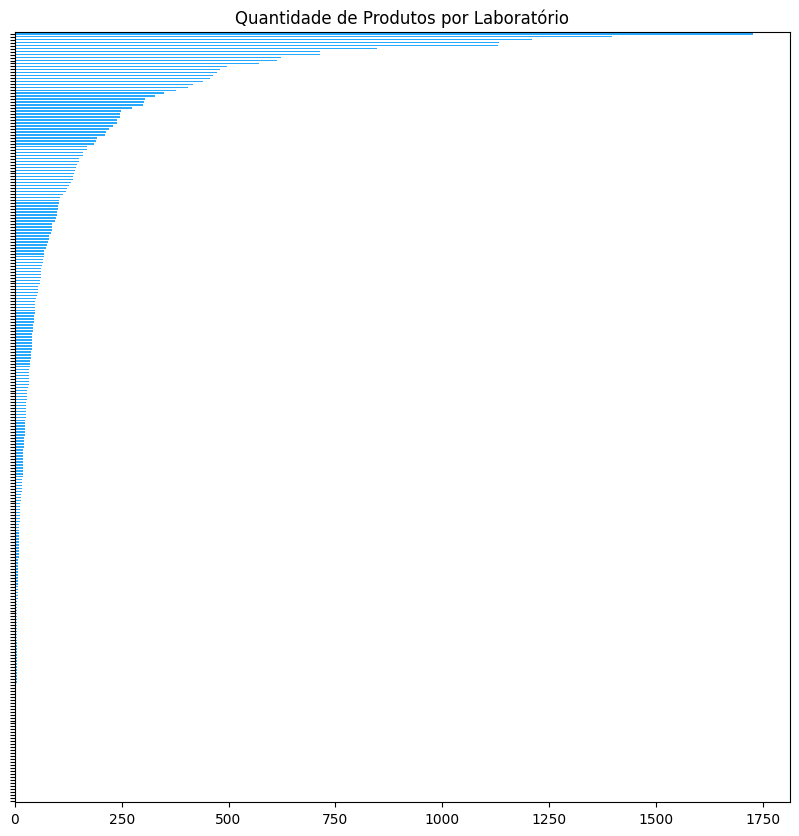

In [22]:
contagem_lab = medicamentos['laboratorio'].value_counts()\
    .sort_values(ascending=True)

ax1 = contagem_lab.plot(
    kind='barh', 
    figsize=(10, 10), 
    color="#27A9FF",
    title='Quantidade de Produtos por Laboratório',
    ylabel='',
)
ax1.set_yticklabels([])
ax1.set_ylabel('')
ax1

# 1. Encontrar 10 maiores laboratórios em número de produtos cadastrados
# 2. Encontrar 10 laboratórios com preço medio mais alto

In [23]:
medicamentos.groupby('laboratorio')['preco_final_consumidor']\
    .mean().sort_values(ascending=True).head(10)

laboratorio
LABORATORIO SIMOES LTDA.                                 9.240000
LABORATÓRIO NEO QUÍMICA COMÉRCIO E INDÚSTRIA LTDA       12.880000
IFAL INDUSTRIA E COMERCIO DE PRODUTOS FARMAC LTDA       16.517500
LABORATORIO INDUSTRIAL FARMACÊUTICO LIFAR LTDA          17.760000
CASA GRANADO LABORATÓRIOS, FARMÁCIAS E DROGARIAS S/A    18.160000
MINÂNCORA & CIA LTDA                                    20.970000
HISAMITSU FARMACÊUTICA DO BRASIL LTDA                   25.424667
DKT DO BRASIL PRODUTOS DE USO PESSOAL LTDA              26.400000
JARRELL FARMACÊUTICA LTDA EPP                           27.255000
SALBEGO LABORATÓRIO FARMACÊUTICO LTDA                   29.710000
Name: preco_final_consumidor, dtype: float64

In [24]:
medicamentos.groupby(medicamentos['laboratorio'])\
    .preco_final_consumidor.mean()\
    .sort_values(ascending=False).head(10)

laboratorio
SPECIALTY PHARMA GOIAS LTDA                                      759313.920000
AMRYT BRASIL COMERCIO E IMPORTACAO DE MEDICAMENTOS LTDA          291977.100000
ALEXION SERVICOS E FARMACEUTICA DO BRASIL LTDA                   194503.636667
PTC FARMACEUTICA DO BRASIL LTDA.                                 181944.130000
VERTEX FARMACEUTICA DO BRASIL LTDA.                              134972.615455
PINT PHARMA PRODUTOS MEDICO-HOSPITALARES E FARMACEUTICOS LTDA     67635.543333
FUNDACAO OSWALDO CRUZ                                             62356.912787
BEONE MEDICINES BRASIL LTDA                                       55773.070000
BIOGEN BRASIL PRODUTOS FARMACEUTICOS LTDA                         46335.330000
GILEAD SCIENCES FARMACEUTICA DO BRASIL LTDA                       44911.727778
Name: preco_final_consumidor, dtype: float64

<Axes: ylabel='laboratorio'>

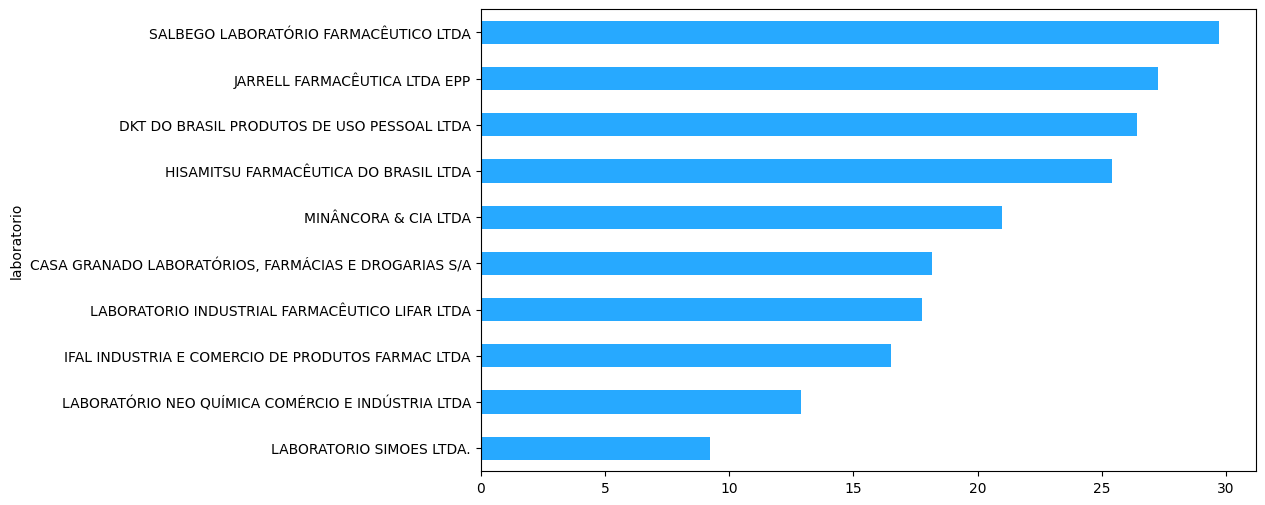

In [25]:
medicamentos.groupby(medicamentos['laboratorio'])\
    .preco_final_consumidor.mean()\
    .sort_values(ascending=True).head(10)\
    .plot(kind='barh', figsize=(10, 6), color="#27A9FF")

<Axes: title={'center': 'Quantidade de Produtos por Laboratório'}>

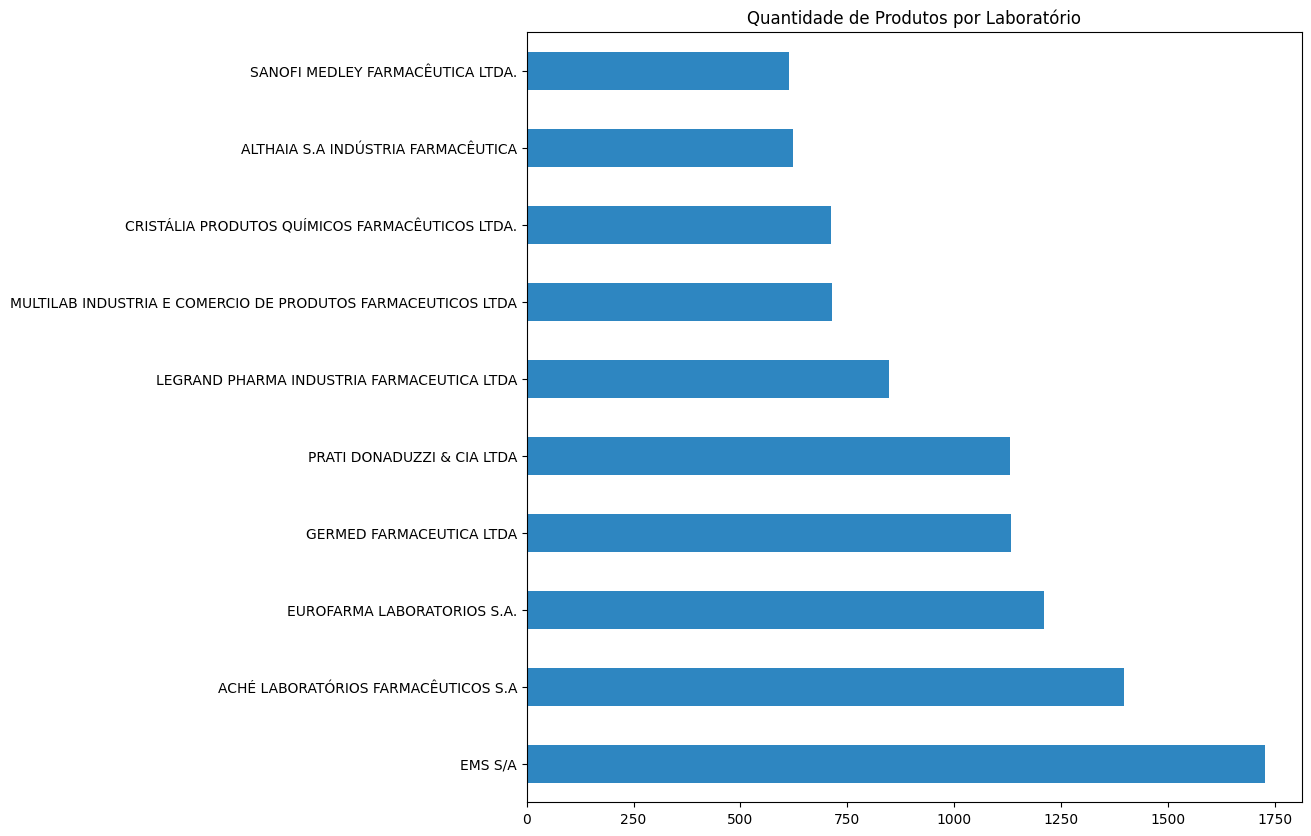

In [26]:
contagem_lab = medicamentos['laboratorio'].value_counts().sort_values(ascending=False).head(10)


ax1 = contagem_lab.plot(
    kind='barh', 
    figsize=(10, 10), 
    color='#2E86C1', 
    title='Quantidade de Produtos por Laboratório',
    ylabel='',
)
ax1

<Axes: title={'center': 'Quantidade de Produtos por Laboratório'}>

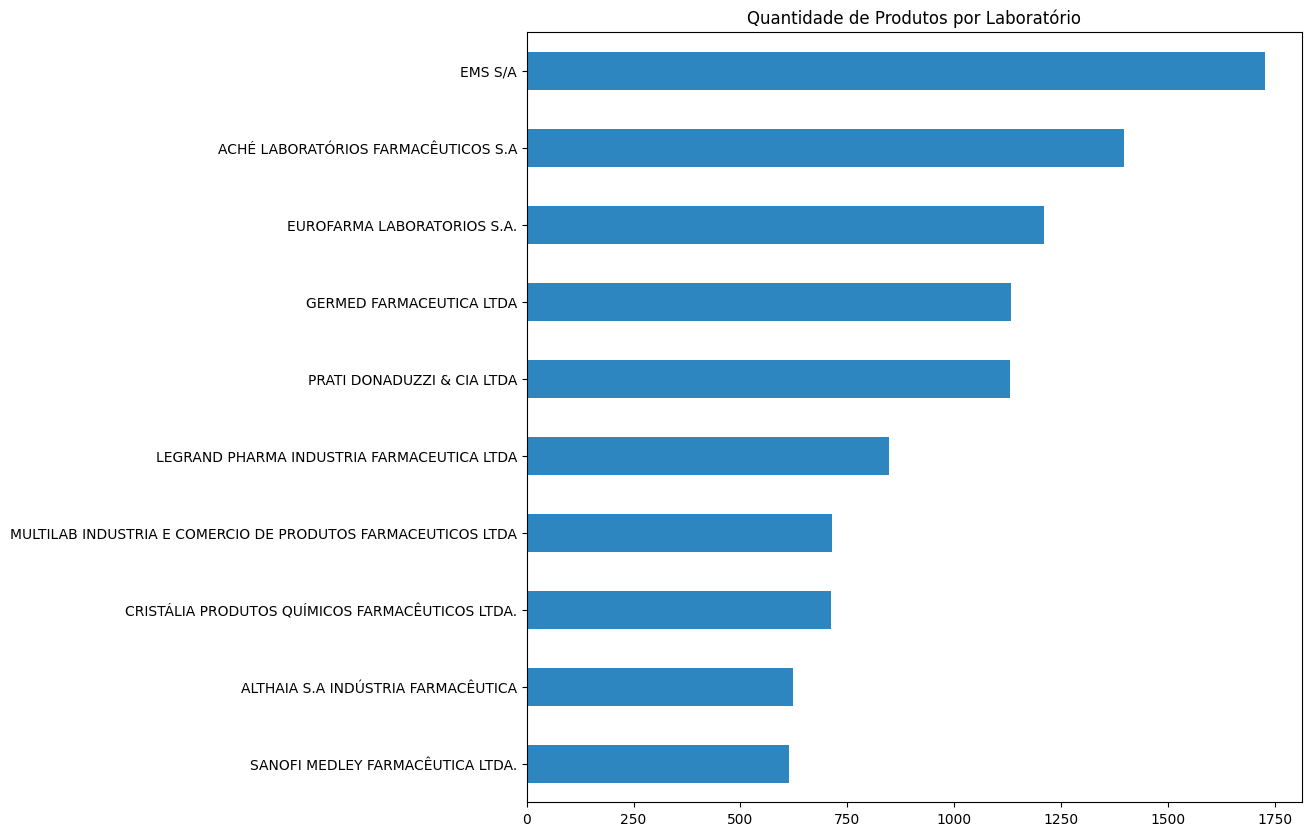

In [27]:
contagem_lab = medicamentos['laboratorio'].value_counts().head(10).sort_values(ascending=True)


ax1 = contagem_lab.plot(
    kind='barh', 
    figsize=(10, 10), 
    color='#2E86C1', 
    title='Quantidade de Produtos por Laboratório',
    ylabel='',
)
ax1

In [28]:
### Aula 10

In [29]:
import pandas as pd
import numpy as np

medicamentos = pd.read_csv('medicamentos_limpo.csv')

In [30]:
medicamentos['tarja'].value_counts()

tarja
Tarja Vermelha                  13600
Sem Tarja                        7281
Tarja Vermelha sob restrição     5142
Tarja Preta                       752
Name: count, dtype: int64

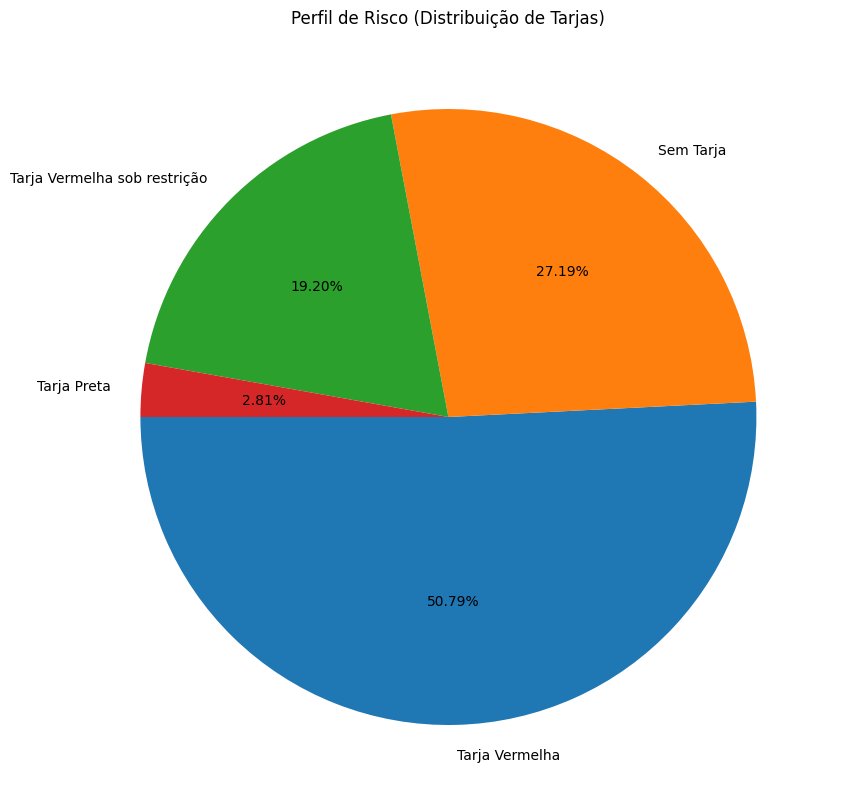

In [31]:
distribuicao_tarja = medicamentos['tarja'].value_counts()

ax2 = distribuicao_tarja.plot(
    kind='pie',
    figsize=(10, 10),
    autopct='%1.2f%%',
    startangle=180,
    title='Perfil de Risco (Distribuição de Tarjas)',
    ylabel='' 
)

<Axes: title={'center': 'preco_final_consumidor'}, xlabel='tipo_produto'>

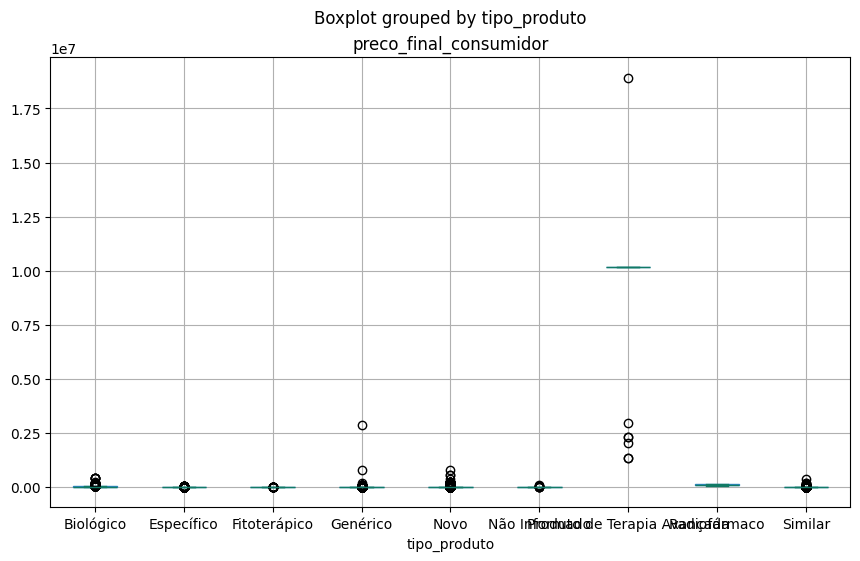

In [32]:
# Configurando o tamanho da figura
medicamentos.boxplot(
    column='preco_final_consumidor', 
    by='tipo_produto',
    figsize=(10, 6),
    patch_artist=True,
    color=dict(boxes='#2E86C1', whiskers='#117A65', medians='#117A65', caps='#117A65'),
)

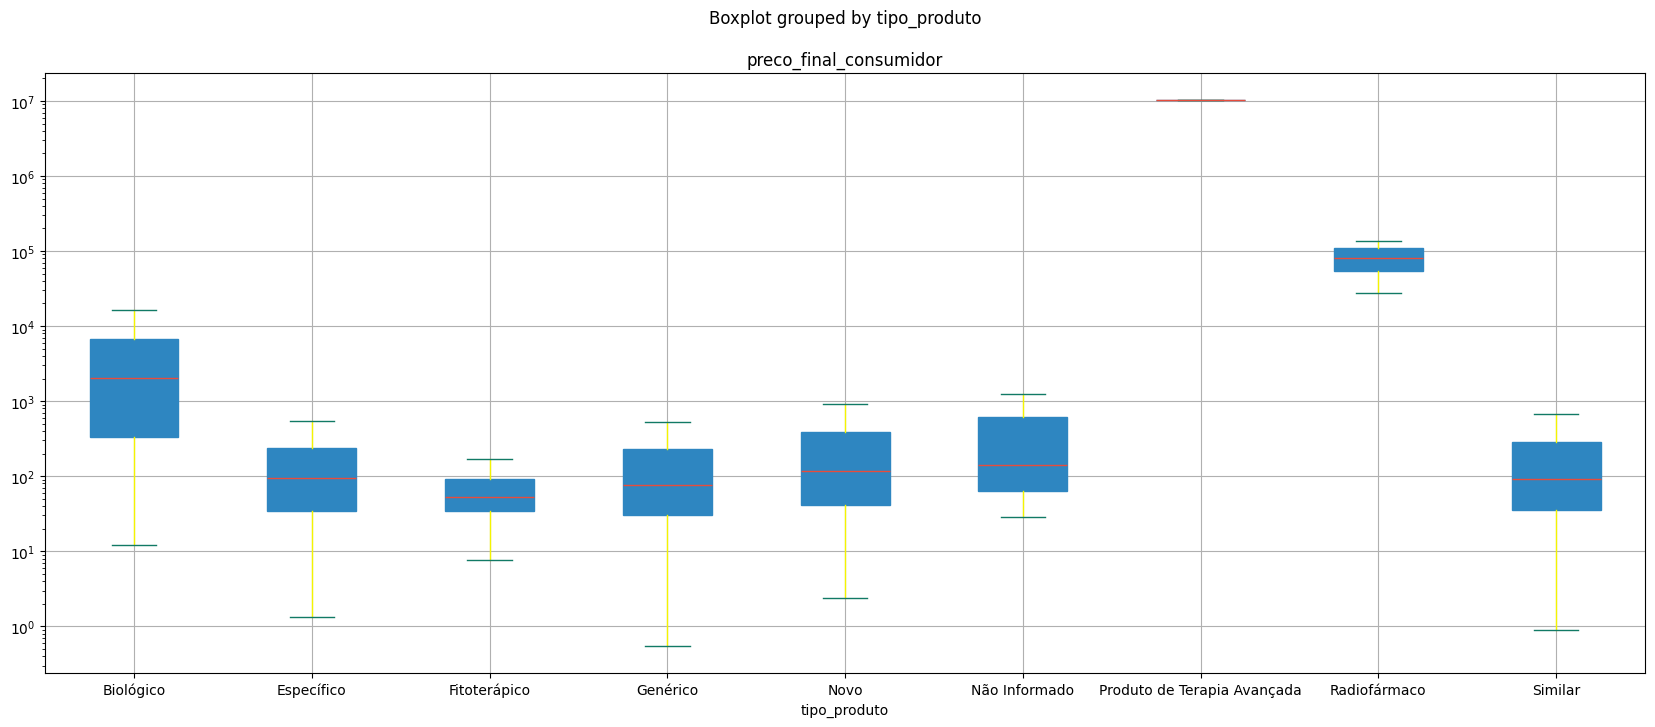

In [33]:
import matplotlib.pyplot as plt
ax = medicamentos.boxplot(
    column='preco_final_consumidor', 
    by='tipo_produto', 
    figsize=(20, 8), # Aumentei um pouco para garantir leitura
    grid=True, # Grid ajuda a ler log
    color=dict(boxes='#2E86C1', whiskers="#F4F401", medians='#e74c3c', caps='#117A65'),
    showfliers=False,
    patch_artist=True 
)
plt.yscale('log') # Transforma o eixo Y em escala logarítmica

In [34]:
np.log(medicamentos.groupby('tipo_produto')['preco_final_consumidor'].mean())

tipo_produto
Biológico                       9.180870
Específico                      5.832707
Fitoterápico                    4.602370
Genérico                        6.996072
Novo                            8.393837
Não Informado                   7.979383
Produto de Terapia Avançada    16.041743
Radiofármaco                   11.312926
Similar                         6.878993
Name: preco_final_consumidor, dtype: float64

In [35]:
np.log(medicamentos.groupby('tipo_produto')['preco_final_consumidor'].describe().iloc[:, 1:])

,mean,std,min,25%,50%,75%,max
tipo_produto,,,,,,,
Biológico,9.180870,10.327764,2.488234,5.798820,7.618399,8.828969,12.946624
Específico,5.832707,6.739558,0.277632,3.531202,4.551400,5.468313,9.024145
Fitoterápico,4.602370,5.339876,2.030776,3.541177,3.960432,4.521843,7.628926
Genérico,6.996072,10.315198,-0.597837,3.418054,4.340553,5.436262,14.866749
Novo,8.393837,10.130478,0.867100,3.735286,4.753676,5.969449,13.579626
Não Informado,7.979383,9.441591,3.343568,4.146304,4.943284,6.406995,11.426258
Produto de Terapia Avançada,16.041743,14.977852,14.094053,16.135515,16.135515,16.135515,16.756377
Radiofármaco,11.312926,11.253877,10.214628,10.907540,11.312926,11.600569,11.823689
Similar,6.878993,8.730199,-0.105361,3.562395,4.533889,5.661518,12.789927


In [36]:
medicamentos.groupby('tarja')['preco_final_consumidor'].mean()

tarja
Sem Tarja                         981.848088
Tarja Preta                       256.581742
Tarja Vermelha                  32963.253583
Tarja Vermelha sob restrição      754.528973
Name: preco_final_consumidor, dtype: float64

In [37]:
medicamentos.groupby('tarja')['preco_final_consumidor'].agg(
    Contagem=('std')
)

,Contagem
tarja,
Sem Tarja,7169.855888
Tarja Preta,540.056031
Tarja Vermelha,556705.886136
Tarja Vermelha sob restrição,3125.537076


In [38]:
import jinja2
import pandas as pd
import numpy as np

# 1. ANÁLISE DE NEGÓCIO (Groupby = Tabela Dinâmica)
# Vamos agrupar por Tipo e calcular métricas chaves
analise_precos = medicamentos.groupby('tipo_produto')['preco_final_consumidor'].agg([
    ('Contagem', 'count'),             # Quantos produtos tem?
    ('Preco_Minimo', 'min'),           # Mais barato
    ('Preco_Medio', 'mean'),           # Média (Cuidado!)
    ('Preco_Mediano', 'median'),       # Mediana (A realidade do mercado)
    ('Preco_Maximo', 'max'),           # Mais caro (Outlier)
    ('Desvio_Padrao', 'std')           # Variação
]).sort_values('Preco_Mediano', ascending=False)

# 2. FORMATANDO COMO PLANILHA (Styler)
# Isso gera uma visualização HTML idêntica ao Excel com formatação condicional
formatacao = {
    'Preco_Minimo': 'R$ {:,.2f}',
    'Preco_Medio': 'R$ {:,.2f}',
    'Preco_Mediano': 'R$ {:,.2f}',
    'Preco_Maximo': 'R$ {:,.2f}',
    'Desvio_Padrao': 'R$ {:,.2f}'
}

print("=== RELATÓRIO DE PRECIFICAÇÃO POR CATEGORIA ===")
display(
    analise_precos.style
    .format(formatacao)
    # Gradiente de cor para destacar os valores altos (Heatmap)
    .background_gradient(subset=['Preco_Mediano', 'Preco_Maximo'], cmap='Reds')
    .background_gradient(subset=['Contagem'], cmap='Blues')
    .set_properties(**{'text-align': 'right'})
    .set_table_styles([
        {'selector': 'th', 'props': [('text-align', 'center'), ('font-weight', 'bold')]}
    ])
)

# 3. INSIGHTS ADICIONAIS
print("\n INSIGHTS PRINCIPAIS:")
print(f"• Total de categorias: {len(analise_precos)}")
print(f"• Categoria mais cara (mediana): {analise_precos['Preco_Mediano'].idxmax()}")
print(f"• Categoria mais barata (mediana): {analise_precos['Preco_Mediano'].idxmin()}")
print(f"• Categoria com mais produtos: {analise_precos['Contagem'].idxmax()} ({int(analise_precos['Contagem'].max())} produtos)")

=== RELATÓRIO DE PRECIFICAÇÃO POR CATEGORIA ===


,Contagem,Preco_Minimo,Preco_Medio,Preco_Mediano,Preco_Maximo,Desvio_Padrao
tipo_produto,,,,,,
Produto de Terapia Avançada,44,"R$ 1,321,202.58","R$ 9,264,894.18","R$ 10,175,722.18","R$ 18,932,240.08","R$ 3,197,410.02"
Radiofármaco,2,"R$ 27,299.63","R$ 81,873.12","R$ 81,873.12","R$ 136,446.61","R$ 77,178.57"
Biológico,1485,R$ 12.04,"R$ 9,709.60","R$ 2,035.30","R$ 419,418.27","R$ 30,569.67"
Não Informado,57,R$ 28.32,"R$ 2,920.13",R$ 140.23,"R$ 91,698.23","R$ 12,601.74"
Novo,3813,R$ 2.38,"R$ 4,419.75",R$ 116.01,"R$ 789,872.13","R$ 25,096.35"
Específico,2182,R$ 1.32,R$ 341.28,R$ 94.77,"R$ 8,301.11",R$ 845.19
Similar,9018,R$ 0.90,R$ 971.65,R$ 93.12,"R$ 358,586.98","R$ 6,186.96"
Genérico,9816,R$ 0.55,"R$ 1,092.33",R$ 76.75,"R$ 2,861,191.01","R$ 30,187.95"
Fitoterápico,358,R$ 7.62,R$ 99.72,R$ 52.48,"R$ 2,056.84",R$ 208.49



 INSIGHTS PRINCIPAIS:
• Total de categorias: 9
• Categoria mais cara (mediana): Produto de Terapia Avançada
• Categoria mais barata (mediana): Fitoterápico
• Categoria com mais produtos: Genérico (9816 produtos)


In [39]:
medicamentos.groupby('tipo_produto')['regime_preco'].value_counts()

tipo_produto                 regime_preco
Biológico                    Regulado        1437
                             Liberado          48
Específico                   Regulado        1747
                             Liberado         435
Fitoterápico                 Liberado         358
Genérico                     Regulado        9245
                             Liberado         571
Novo                         Regulado        3412
                             Liberado         401
Não Informado                Regulado          53
                             Liberado           4
Produto de Terapia Avançada  Regulado          44
Radiofármaco                 Regulado           2
Similar                      Regulado        8005
                             Liberado        1013
Name: count, dtype: int64

In [40]:
resultado = medicamentos.groupby(['regime_preco', 'tipo_produto'])['regime_preco'].count()


<Axes: ylabel='regime_preco,tipo_produto'>

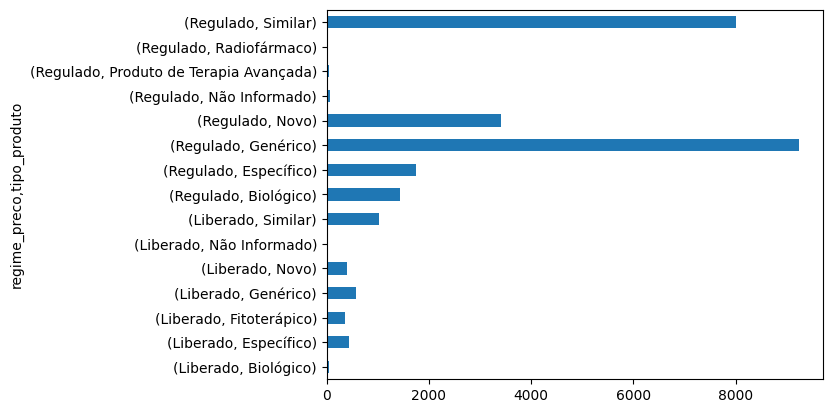

In [41]:
resultado.plot(
    kind='barh'
)

In [42]:
(medicamentos['laboratorio'] == 'PFIZER BRASIL LTDA') | (medicamentos['laboratorio'] == 'TAKEDA PHARMA LTDA.')

0        False
1        False
2        False
3        False
4        False
         ...  
26770    False
26771    False
26772    False
26773    False
26774    False
Name: laboratorio, Length: 26775, dtype: bool

In [43]:
lab1 = "PFIZER BRASIL LTDA"
lab2 = "TAKEDA PHARMA LTDA."

In [44]:
laboratorios_filtro = (medicamentos['laboratorio'] == lab2) | (medicamentos['laboratorio'] == lab1)

In [45]:
comparacao = medicamentos[laboratorios_filtro]

In [46]:
comparacao.groupby(['laboratorio', 'tipo_produto'])['preco_final_consumidor'].describe()

count          mean           std     min  \
laboratorio         tipo_produto                                               
PFIZER BRASIL LTDA  Biológico       62.0  14866.633548  32411.820385   28.30   
                    Específico       2.0    921.220000    434.262559  614.15   
                    Genérico         3.0   2147.660000   2502.388583  356.40   
                    Novo           123.0   8008.086423  18766.140840    8.40   
                    Não Informado    2.0   1276.695000   1477.266274  232.11   
                    Similar         29.0   1778.499655   4560.293216   13.59   
TAKEDA PHARMA LTDA. Biológico       92.0   8857.636630  16091.533437  293.65   
                    Específico       7.0    114.295714    191.229151    7.95   
                    Novo            80.0   5104.143875  15725.069830    6.49   
                    Similar         11.0    156.744545    171.669906   17.52   

                                         25%       50%         75%        max  
laboratorio         tipo_produto                                               
PFIZER BRASIL LTDA  Biológico      1951.0900  5777.135  11706.5500  228277.74  
                    Específico      767.6850   921.220   1074.7550    1228.29  
                    Genérico        718.0750  1079.750   3043.2900    5006.83  
                    Novo             79.9600   700.800   6830.7250  126127.86  
                    Não Informado   754.4025  1276.695   1798.9875    2321.28  
                    Similar          43.6800   104.070    152.7700   18513.73  
TAKEDA PHARMA LTDA. Biológico      2226.2000  4468.725   9029.4500  128009.74  
                    Específico       21.3850    30.850     91.2500     536.00  
                    Novo             70.0625   192.525    445.1850  113191.32  
                    Similar          36.5500    70.870    256.0300     442.40

In [47]:
comparacao['tipo_produto'].value_counts()

tipo_produto
Novo             203
Biológico        154
Similar           40
Específico         9
Genérico           3
Não Informado      2
Name: count, dtype: int64

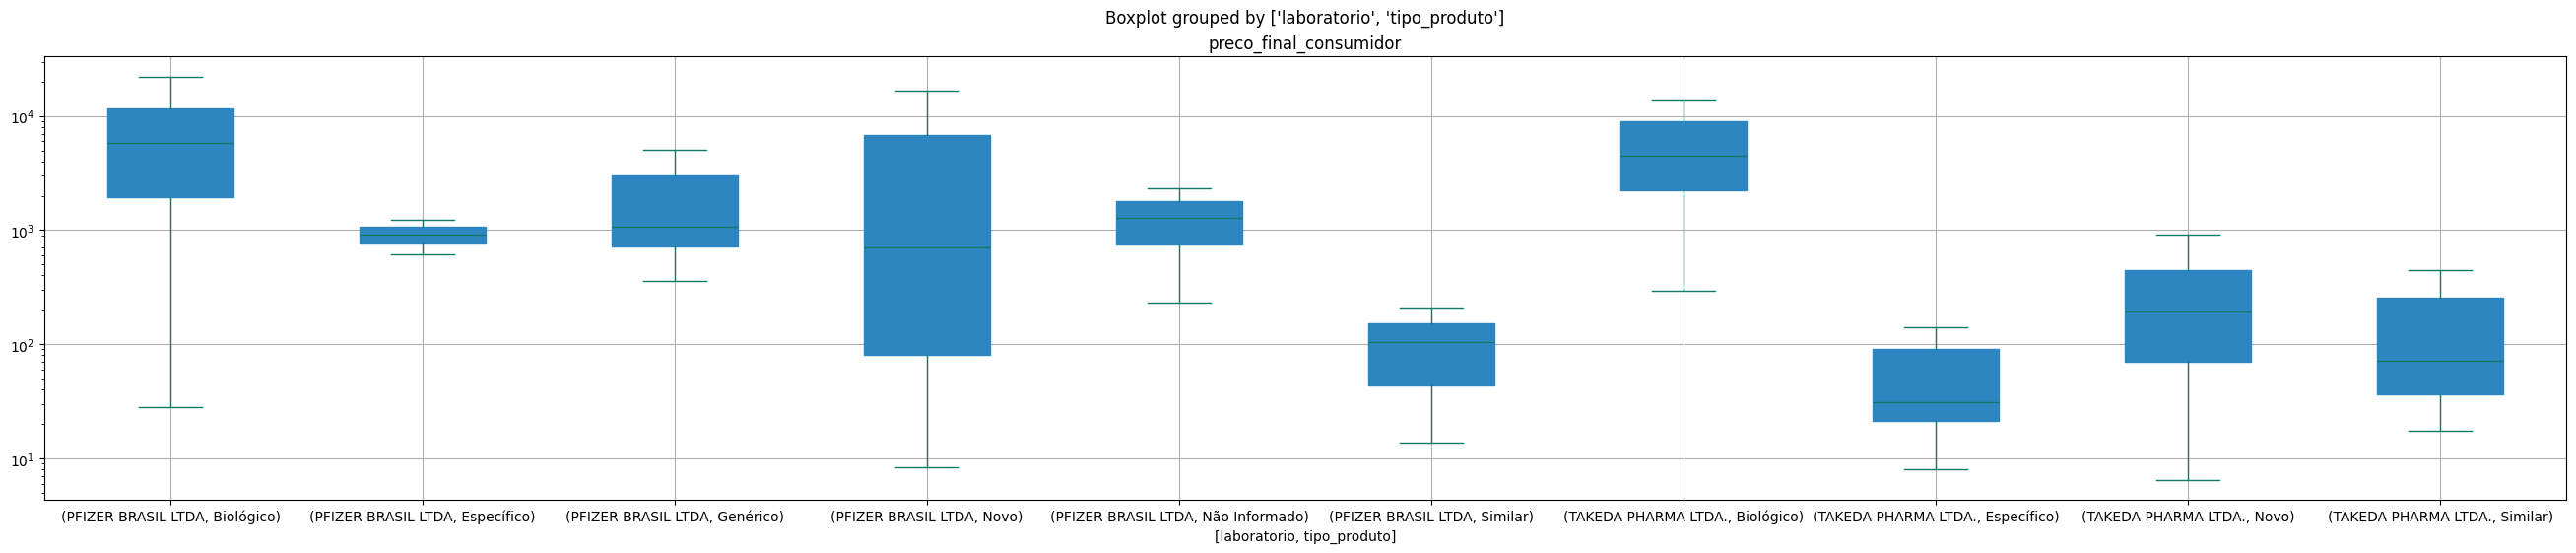

In [48]:
ax3 = comparacao.boxplot(
    column='preco_final_consumidor',
    by=['laboratorio', 'tipo_produto'],
    figsize=(32, 6),
    showfliers=False,
    patch_artist=True,
    color=dict(boxes='#2E86C1', whiskers='#117A65', medians='#117A65', caps='#117A65'),
)
ax3.set_yscale('log')

In [49]:
import matplotlib.pyplot as plt

In [50]:
historico_medicamentos['ano'].unique()

array([2025, 2024, 2023, 2022, 2021])

In [51]:
historico_medicamentos.dropna(subset=['preco_final_consumidor'], inplace=True)

In [52]:
x = historico_medicamentos['ano']
y = historico_medicamentos['preco_final_consumidor']
y.head()

0       49.06
2    11107.63
3     5104.43
4    10208.83
5    14659.01
Name: preco_final_consumidor, dtype: float64

In [53]:
inclincacao, intercepto = np.polyfit(x, y, 1)
inclincacao

np.float64(293.42274990463335)

Velocidade de Crescimento Anual: R$ 293.42 / ano
🔮 PREVISÃO PARA 2026: R$ 2,313.31


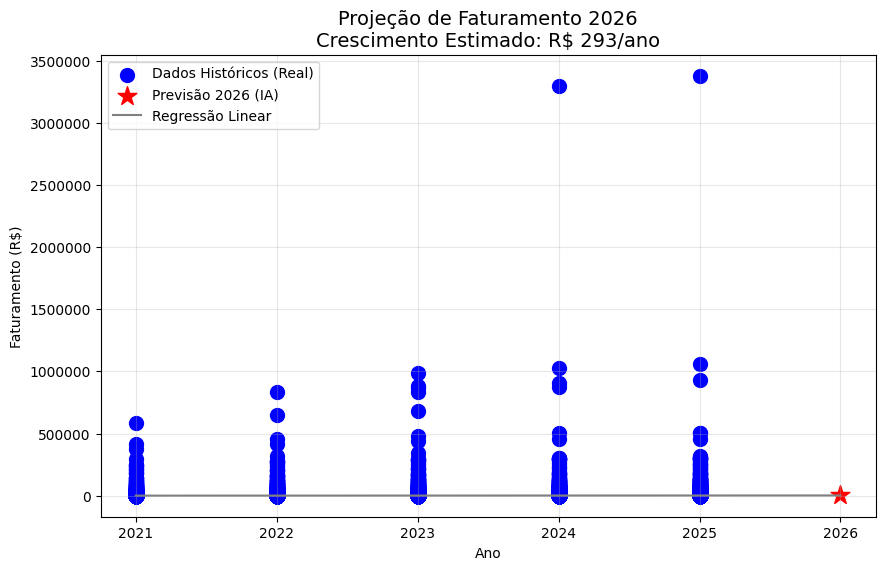

In [54]:
x = historico_medicamentos['ano']
y = historico_medicamentos['preco_final_consumidor']

# np.polyfit(x, y, 1) -> O '1' significa "Equação de 1º Grau" (Uma Reta)
# Ele retorna dois números: 
# 'a' (inclinação da reta/velocidade de crescimento)
# 'b' (onde a reta corta o eixo Y/ponto de partida teórico)
inclincacao, intercepto = np.polyfit(x, y, 1)

print(f"Velocidade de Crescimento Anual: R$ {inclincacao:,.2f} / ano")


ano_futuro = 2026
previsao_2026 = (inclincacao * ano_futuro) + intercepto

print(f"🔮 PREVISÃO PARA 2026: R$ {previsao_2026:,.2f}")



anos_para_plotar = np.array([2021, 2022, 2023, 2024, 2025, 2026])
linha_tendencia = (inclincacao * anos_para_plotar) + intercepto

plt.figure(figsize=(10, 6))


plt.scatter(x, y, color='blue', s=100, label='Dados Históricos (Real)')

# Ponto Futuro (Estrela Vermelha)
plt.scatter(2026, previsao_2026, color='red', s=200, marker='*', label='Previsão 2026 (IA)')

# Linha de Tendência
plt.plot(anos_para_plotar, linha_tendencia, color='gray', label='Regressão Linear')

plt.title(f'Projeção de Faturamento 2026\nCrescimento Estimado: R$ {inclincacao:,.0f}/ano', fontsize=14)
plt.xlabel('Ano')
plt.ylabel('Faturamento (R$)')
plt.grid(True, alpha=0.3)
plt.legend()

# Formatando eixo Y para não ficar notação científica
plt.ticklabel_format(style='plain', axis='y') 

plt.show()

In [55]:
x = historico_medicamentos['ano']
y = historico_medicamentos['preco_final_consumidor']

In [56]:
historico_medicamentos.columns

Index(['ativo', 'CNPJ', 'laboratorio', 'registro', 'EAN 1', 'EAN 2', 'EAN 3',
       'produto', 'apresentacao', 'classe_terapeutica', 'tipo_produto',
       'regime_preco', 'restricao_hospitalar', 'comercializavel', 'tarja',
       'preco_final_consumidor', 'ano'],
      dtype='object')

In [57]:
df_limpo = historico_medicamentos.dropna(subset=['preco_final_consumidor'])

print(f"Linhas originais: {len(historico_medicamentos)}")
print(f"Linhas sem nan: {len(df_limpo)}")

# agrupamento anual e soma
dados_anuais = df_limpo.groupby('ano')['preco_final_consumidor']\
    .sum()\
    .reset_index()

# Ajustando para milhões/bilhões para ficar legível no gráfico
dados_anuais['valor_milhoes'] = dados_anuais['preco_final_consumidor'] / 1e5

print("\nEVOLUÇÃO DO MERCADO (Em 10 milhoes R$) ===")
display(dados_anuais)

Linhas originais: 112835
Linhas sem nan: 112835

EVOLUÇÃO DO MERCADO (Em 10 milhoes R$) ===


,ano,preco_final_consumidor,valor_milhoes
0,2021,19097585.45,190.975854
1,2022,26093444.90,260.934449
2,2023,32852910.32,328.529103
3,2024,37882628.07,378.826281
4,2025,45777481.33,457.774813


In [58]:
# Regressão Linear

# Eixo X (Tempo) e Eixo Y (Dinheiro)
x = dados_anuais['ano'].values
y = dados_anuais['valor_milhoes'].values

# Criando o modelo (y = ax + b)
# deg=1 significa grau 1 (uma reta)
inclination, intercept = np.polyfit(x, y, 1)

# Prevendo 2026
ano_futuro = 2026
previsao_2026 = (inclination * ano_futuro) + intercept

print(f"Crescimento Anual Médio: R$ {inclination*1000:.2f} Milhões")
print(f"Previsão do Valor Total para 2026: R$ {previsao_2026:.2f} Milhoes")

Crescimento Anual Médio: R$ 65148.97 Milhões
Previsão do Valor Total para 2026: R$ 518.86 Milhoes


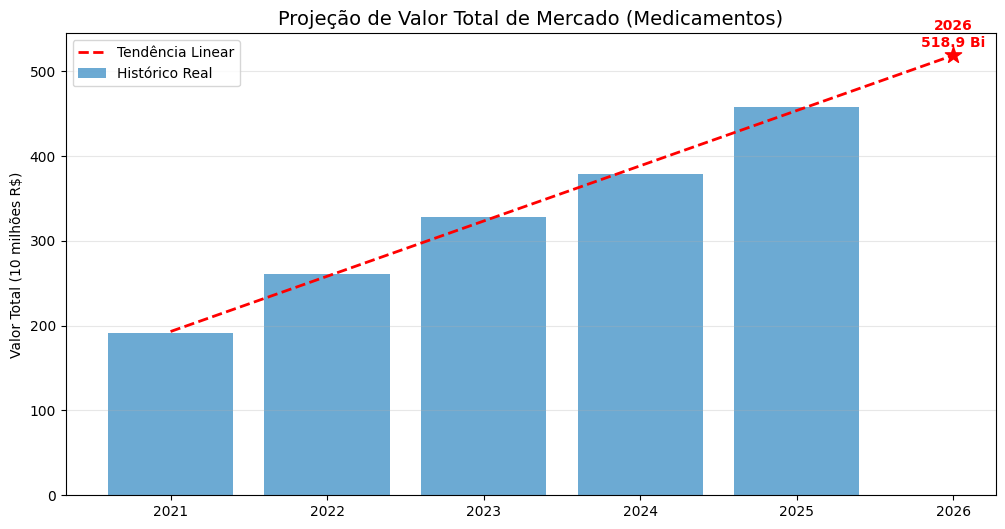

In [59]:
# Criando pontos para a linha de tendência (do primeiro ano até 2026)
anos_linha = np.arange(x.min(), 2027) 
valores_linha = (inclination * anos_linha) + intercept

plt.figure(figsize=(12, 6))

# 1. Plotando os dados Reais (Barras ou Bolinhas)
plt.bar(x, y, color='#2E86C1', alpha=0.7, label='Histórico Real')

# 2. Plotando a Linha de Tendência (Tracejada)
plt.plot(anos_linha, valores_linha, color='red', linestyle='--', linewidth=2, label='Tendência Linear')

# 3. Destacando o Ponto Futuro (2026)
plt.scatter(2026, previsao_2026, color='red', s=150, zorder=5, marker='*')
plt.text(2026, previsao_2026 + (previsao_2026*0.02), # Texto um pouco acima do ponto
         f"2026\n{previsao_2026:.1f} Bi", 
         ha='center', color='red', fontweight='bold')

plt.title('Projeção de Valor Total de Mercado (Medicamentos)', fontsize=14)
plt.ylabel('Valor Total (10 milhões R$)')
plt.xticks(anos_linha) # Garante que mostre todos os anos no eixo X
plt.grid(axis='y', alpha=0.3)
plt.legend()

plt.show()

In [61]:

nome_remedio = 'DIPIRONA' # Aquele biológico caro do seu exemplo
df_remedio = df_limpo[df_limpo['produto'] == nome_remedio]

historico_remedio = df_remedio.groupby('ano')['preco_final_consumidor'].mean().reset_index()

# regressão linear específica do remédio
X_remedio = historico_remedio['ano'].values
y_remedio = historico_remedio['preco_final_consumidor'].values

# Calcula a inclinação e intercepto ESPECÍFICOS deste remédio
incl_r, inter_r = np.polyfit(X_remedio, y_remedio, 1)

# Mágica! Previsão para 2026
preco_2026 = (incl_r * 2026) + inter_r

print(f"ANÁLISE INDIVIDUAL: {nome_remedio}")
print(f"Tendência Anual: {incl_r:.2f} (Se positivo sobe, negativo cai)")
print(f"Preço Estimado 2026: R$ {preco_2026:.2f}")


ANÁLISE INDIVIDUAL: DIPIRONA
Tendência Anual: 1.34 (Se positivo sobe, negativo cai)
Preço Estimado 2026: R$ 57.44


In [62]:
def regredir_linear(df, coluna, valor):
    df_remedio = df[df[coluna] == valor]

    historico_remedio = df_remedio.groupby('ano')['preco_final_consumidor'].mean().reset_index()

    # regressão linear específica do remédio
    x_remedio = historico_remedio['ano'].values
    y_remedio = historico_remedio['preco_final_consumidor'].values

    # Calcula a inclinação e intercepto ESPECÍFICOS deste remédio
    incl_r, inter_r = np.polyfit(x_remedio, y_remedio, 1)

    # Mágica! Previsão para 2026
    preco_2026 = (incl_r * 2026) + inter_r

    print(f"ANÁLISE INDIVIDUAL: {valor}")
    print(f"Tendência Anual: {incl_r:.2f} (Se positivo sobe, negativo cai)")
    print(f"Preço Estimado 2026: R$ {preco_2026:.2f}")


In [63]:
df_limpo['laboratorio'] == 'Pfizer'

0         False
2         False
3         False
4         False
5         False
          ...  
135242    False
135243    False
135244    False
135245    False
135246    False
Name: laboratorio, Length: 112835, dtype: bool